# Transient Search in Open H.E.S.S. Data for mh15-52

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm


from astropy import units as u
from astropy.coordinates import SkyCoord



from regions import CircleSkyRegion
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.maps import WcsGeom, MapAxis
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker


## Loading datasets and performing a simple gammapy analysis

In [2]:
data_store = DataStore.from_dir(f'../gammapy-datasets/{os.listdir("../gammapy-datasets/")[0]}/hess-dl3-dr1/')
data_store.info()

Data store:
HDU index table:
BASE_DIR: ../gammapy-datasets/1.0.1/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105

Data store:
HDU index table:
BASE_DIR: ../gammapy-datasets/1.0.1/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [3]:
position_src = SkyCoord(228.50, -59.16, unit="deg", frame="icrs").icrs #mh15-52 hess position
position_src

<SkyCoord (ICRS): (ra, dec) in deg
    (228.5, -59.16)>

In [4]:
# Define Analysis configuration

energy_axis = MapAxis.from_energy_bounds(0.4, 10, 10, unit="TeV")

geom = WcsGeom.create(
    skydir=(position_src.ra.degree, position_src.dec.degree),
    binsz=0.02,
    width=(5, 5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.2, 20, 30, unit="TeV", name="energy_true"
)

stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="sc-stacked"
)

offset_max = 3 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)

circle = CircleSkyRegion(
    center=position_src, radius=0.5 * u.deg
)

data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask) 

In [5]:
%%time

# perform Analysis

selection_sc = dict(
                    type="sky_circle",
                    frame="icrs",
                    lon=f"{position_src.ra.degree}",
                    lat=f"{position_src.dec.degree}",
                    radius="5 deg",
                    )

sc_obs_table = data_store.obs_table.select_observations(selection_sc)

obs_list = sc_obs_table["OBS_ID"]

observations = data_store.get_observations(obs_list)

events_sc = []



for obs in tqdm(observations[:]):

    if obs.bkg != None:

        try:

            # First a cutout of the target map is produced
            cutout = stacked.cutout(
                obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
            )
            # A MapDataset is filled in this cutout geometry
            dataset = maker.run(cutout, obs)
            # The data quality cut is applied
            dataset = maker_safe_mask.run(dataset, obs)
            # fit background model
            dataset = maker_fov.run(dataset)
            
            print(f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:2.2f}")
            stacked.stack(dataset)
            
            events_sc.append(data_store.obs(obs.obs_id).events)
        except (SystemExit, KeyboardInterrupt):
            raise
        except Exception:

            print(f"\nbad obs.! obs. {obs.obs_id}\n")


  0%|          | 0/20 [00:00<?, ?it/s]

Background norm obs 20136: 1.26
Background norm obs 20137: 1.39
Background norm obs 20151: 1.17
Background norm obs 20282: 1.12
Background norm obs 20283: 0.79
Background norm obs 20301: 1.13
Background norm obs 20302: 1.16
Background norm obs 20303: 1.11
Background norm obs 20322: 1.25
Background norm obs 20323: 1.16
Background norm obs 20324: 1.20
Background norm obs 20325: 1.17
Background norm obs 20343: 1.19
Background norm obs 20344: 1.23
Background norm obs 20345: 1.14
Background norm obs 20346: 1.22
Background norm obs 20365: 1.20
Background norm obs 20366: 1.08
Background norm obs 20367: 1.12
Background norm obs 20368: 1.08
CPU times: user 52.8 s, sys: 5.01 s, total: 57.8 s
Wall time: 58.4 s


In [6]:
print(stacked) # check if loaded properly

MapDataset
----------

  Name                            : sc-stacked 

  Total counts                    : 115194 
  Total background counts         : 114168.75
  Total excess counts             : 1025.25

  Predicted counts                : 114168.74
  Predicted background counts     : 114168.75
  Predicted excess counts         : nan

  Exposure min                    : 1.96e+02 m2 s
  Exposure max                    : 1.33e+10 m2 s

  Number of total bins            : 625000 
  Number of fit bins              : 613600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




<WCSAxesSubplot: >

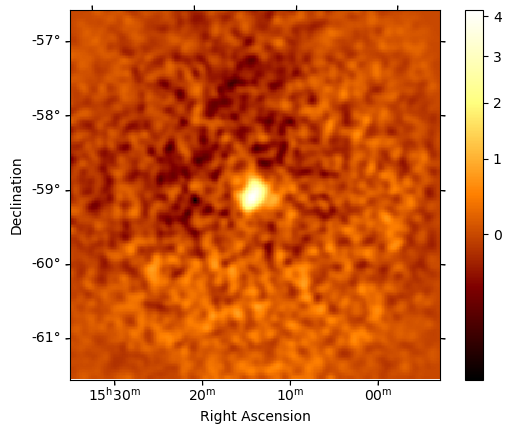

In [7]:
stacked.excess.sum_over_axes().smooth(0.05 * u.deg).plot(stretch="sqrt", add_cbar=True) # check if loaded properly

## Import Transient search library and perform searches

In [8]:
from gamma_transients import core, photon, smallest_enc_circ

scanner = core.scanner_parallel # import non-paralell version if not supported by your system
plotter = core.triplet_hist2d_plotter # helper funnction for plotting

229.45326


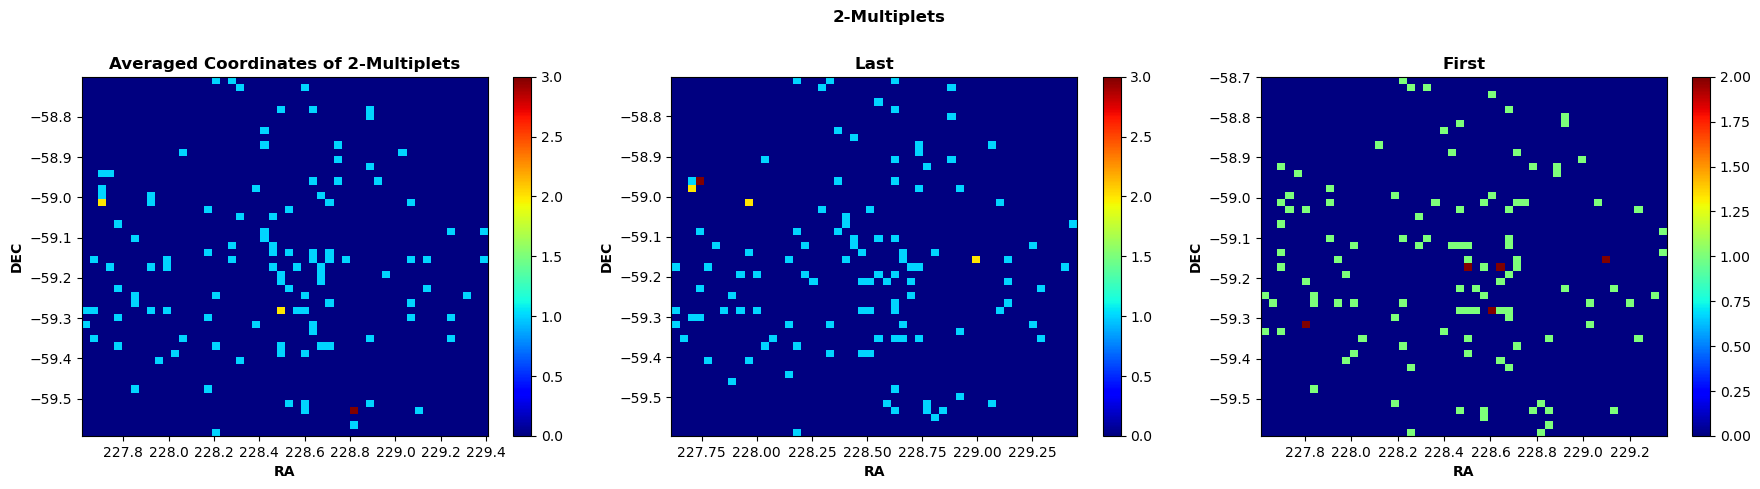

Nmax,ID,RA,DEC,TIME,ENERGY,dt,da
int64,int64[2],float32[2],float32[2],datetime64[ns][2],float32[2],float64,float64
2,2774548873888 .. 2774548874190,228.26036 .. 228.34117,-59.425835 .. -59.393806,2004-03-26T03:12:54.678275878 .. 2004-03-26T03:12:55.643238837,3.0945363 .. 0.40252656,964962944.0,0.08692611787533959
2,3582002725367 .. 3582002725441,228.48367 .. 228.5758,-59.52685 .. -59.512413,2004-03-26T03:25:31.041909510 .. 2004-03-26T03:25:31.312447125,0.56079865 .. 0.47157404,270537600.0,0.09325708640225373
2,3612067496473 .. 3612067496723,228.78304 .. 228.85597,-59.536423 .. -59.535885,2004-03-26T03:28:31.392756039 .. 2004-03-26T03:28:32.242286736,0.41788718 .. 1.0587044,849530624.0,0.07293899495528938
2,3878355468752 .. 3878355468847,228.6421 .. 228.65169,-59.27264 .. -59.358906,2004-03-27T02:32:07.860743338 .. 2004-03-27T02:32:08.200668389,2.356539 .. 2.1747203,339925120.0,0.08679615317938541
2,3908420240417 .. 3908420240509,228.2351 .. 228.21356,-59.270424 .. -59.200897,2004-03-27T02:32:37.906557614 .. 2004-03-27T02:32:38.182820613,0.47736904 .. 0.3549455,276263040.0,0.07278848032973417
2,4333622002702 .. 4337916968977,227.64693 .. 227.72046,-59.267395 .. -59.300472,2004-03-27T02:39:16.603974635 .. 2004-03-27T02:39:17.195426280,0.44649735 .. 0.3560375,591451648.0,0.080629239091173
2,4376571674938 .. 4376571674992,228.22562 .. 228.15027,-59.107967 .. -59.16284,2004-03-27T02:39:54.501341397 .. 2004-03-27T02:39:54.759962851,0.35287273 .. 1.1769978,258621440.0,0.0932121670267995
2,4453881086840 .. 4453881087099,229.03043 .. 229.12538,-59.26933 .. -59.266518,2004-03-27T02:41:08.883484418 .. 2004-03-27T02:41:09.709339673,0.8505164 .. 0.36954355,825855232.0,0.09499705552425297
2,4840428143474 .. 4840428143661,228.62079 .. 228.6001,-59.280544 .. -59.21649,2004-03-27T02:47:11.446759755 .. 2004-03-27T02:47:12.088625723,1.0696316 .. 1.5906781,641865856.0,0.06731156899065627


In [9]:
# search an area with radius 0.5 deg around the source position, with maximum enclosing circle of diameter 0.1 deg and max duration 1s (1e9 ns)
# Nmin=2, Nmax=2 to search for doublets

multiplets = scanner(position_src, events_sc, dt_threshold=1e9, r_deg=0.1, r_area=0.5, Nmin=2, Nmax=2)
plotter(multiplets,bins=50)
multiplets

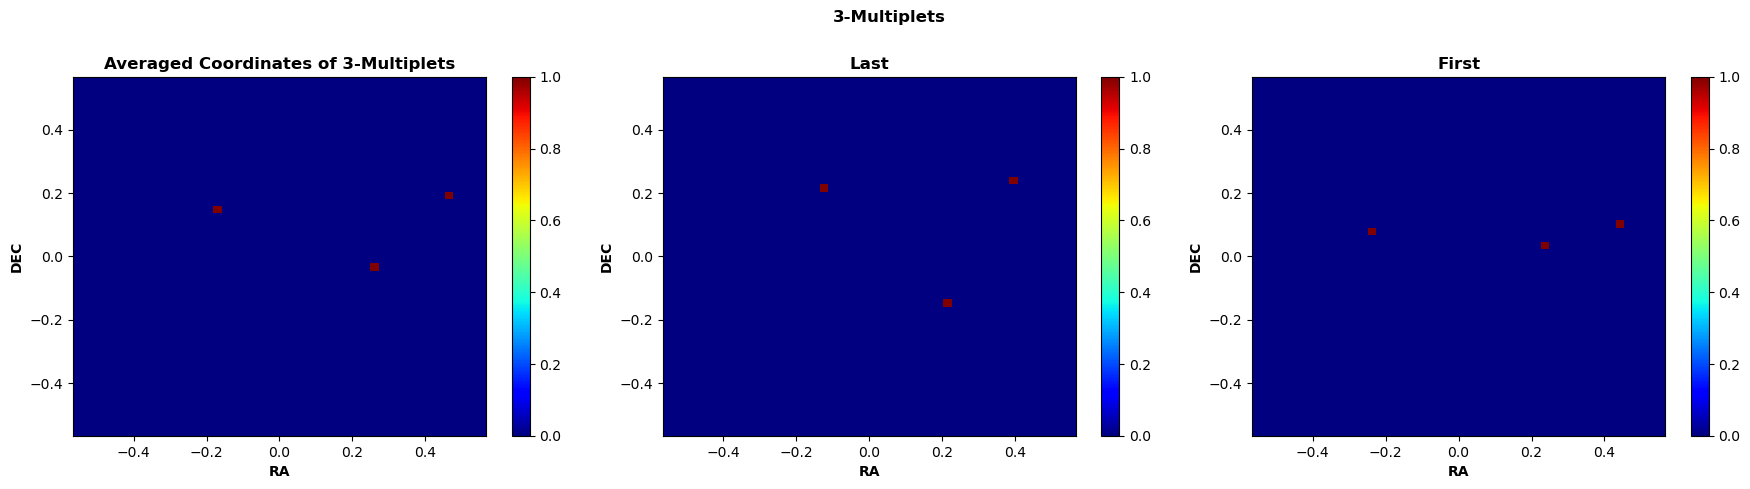

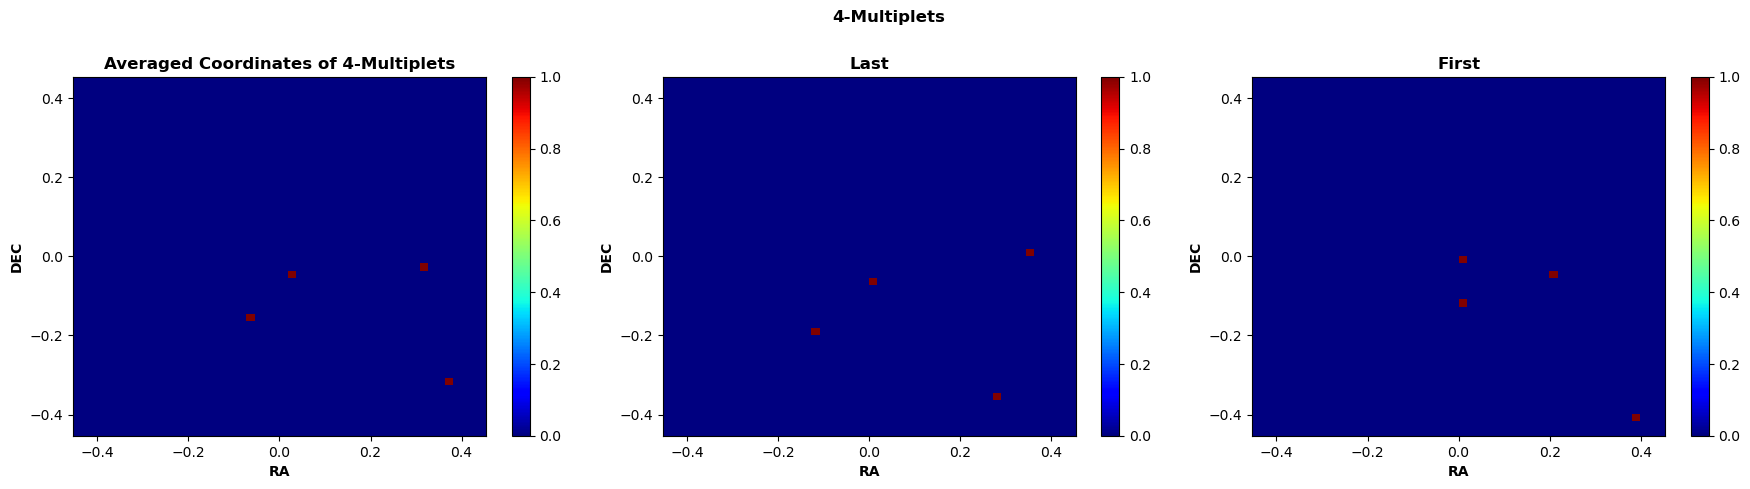

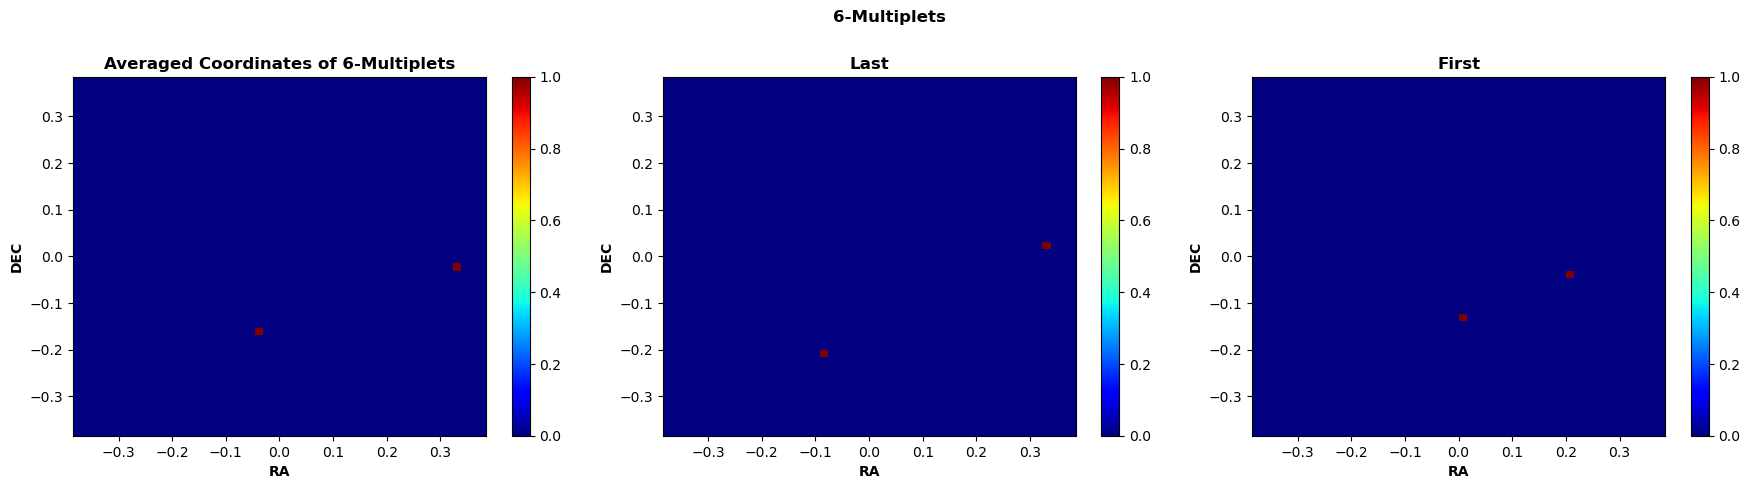

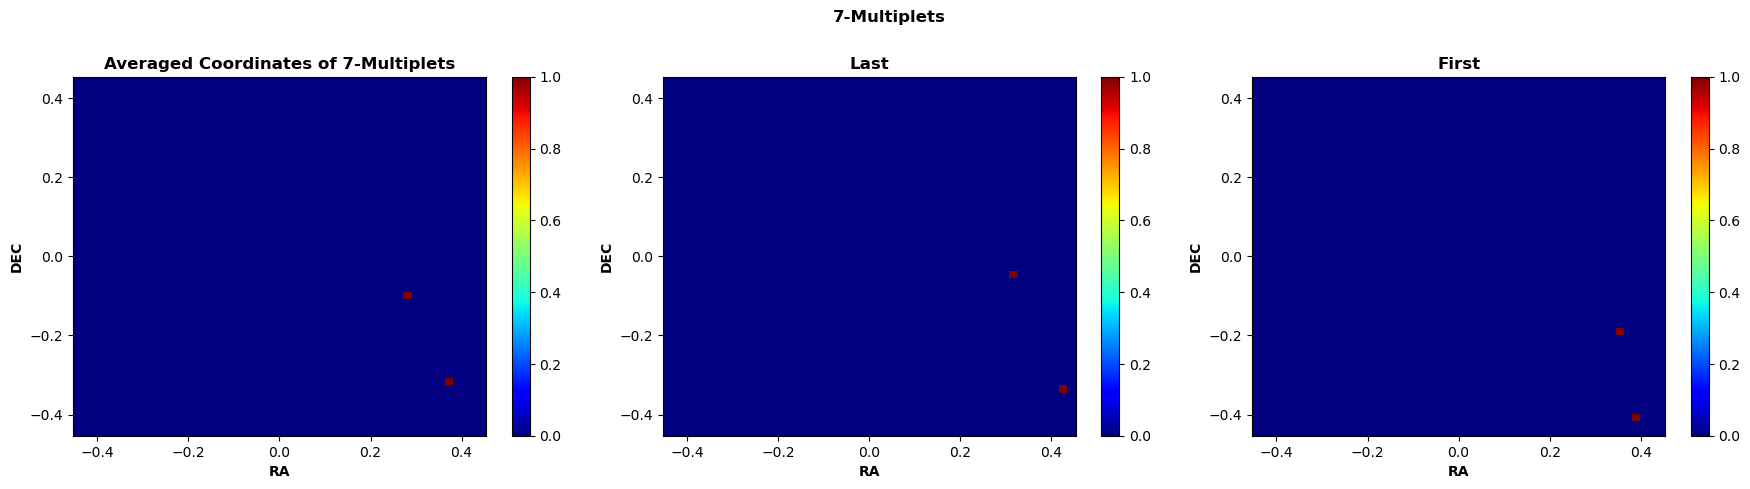

In [10]:
triplets_1s = scanner(position_src, events_sc, dt_threshold=1e9, r_deg=0.2, r_area=0.5, Nmin=3, Nmax=3)
plotter(triplets_1s, bins=50, position_src=position_src)
fourplets_7s = scanner(position_src, events_sc, dt_threshold=7*1e9, r_deg=0.2, r_area=0.5, Nmin=4, Nmax=4)
plotter(fourplets_7s, bins=50, position_src=position_src)
sixplets_20s = scanner(position_src, events_sc, dt_threshold=20*1e9, r_deg=0.2, r_area=0.5, Nmin=6, Nmax=6)
plotter(sixplets_20s, bins=50, position_src=position_src)
sevenplets_40s = scanner(position_src, events_sc, dt_threshold=40*1e9, r_deg=0.2, r_area=0.5, Nmin=7, Nmax=7)
plotter(sevenplets_40s, bins=50, position_src=position_src)

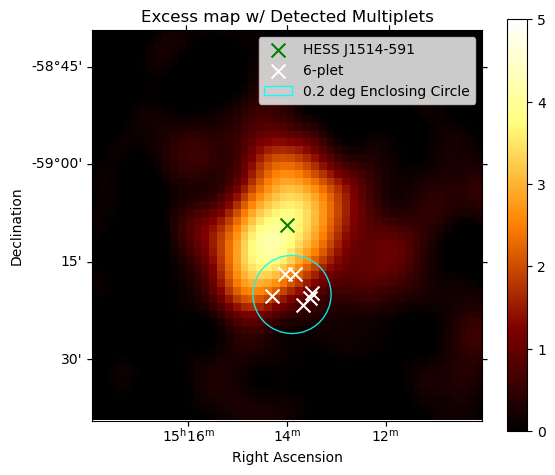

In [12]:
make_circle = smallest_enc_circ.make_circle
circ6_1 = make_circle(np.c_[sixplets_20s[0]['RA'], sixplets_20s[0]['DEC']])

wx = wy = 1 * u.deg


fig_ = plt.figure(figsize=(6, 5))
fig = stacked.excess.sum_over_axes().smooth(0.05 * u.deg).cutout(position=position_src, width=(wx, wy))

fig.plot(stretch = "linear", vmin=0, vmax=5,
                   add_cbar = True)


plt.gca().scatter(position_src.ra.deg, position_src.dec.deg, marker = 'x', color = 'green', transform=plt.gca().get_transform("icrs"), s=100, label = 'HESS J1514-591')

plt.gca().scatter(sixplets_20s[0]['RA'], sixplets_20s[0]['DEC'], marker = 'x', color = 'white', transform=plt.gca().get_transform("icrs"), s=100, label = '6-plet')


center_coord = SkyCoord(circ6_1[0], circ6_1[1], unit = 'deg', frame="icrs")
region = CircleSkyRegion(center_coord, radius=0.1*u.deg).to_pixel(fig.geom.wcs)
region.plot(ax = plt.gca(), edgecolor='cyan', alpha=0.9, lw=1, label = '0.2 deg Enclosing Circle')

plt.title("Excess map w/ Detected Multiplets")

plt.legend()
plt.tight_layout()
#plt.savefig("plots_paper/6plet_20s.pdf")


In [13]:
sevenplets_40s

Nmax,ID,RA,DEC,TIME,ENERGY,dt,da
int64,int64[7],float32[7],float32[7],datetime64[ns][7],float32[7],float64,float64
7,20903605830576 .. 20946555502934,228.85323 .. 228.81714,-59.34295 .. -59.20907,2004-04-17T01:17:51.028925234 .. 2004-04-17T01:18:29.469134146,0.43070257 .. 0.3481582,38440209024.0,0.17852232103691382
7,22827751178258 .. 22857815950198,228.88669 .. 228.93051,-59.56955 .. -59.48956,2004-04-19T00:40:50.634839827 .. 2004-04-19T00:41:21.902690703,0.46791118 .. 1.4470881,31267850880.0,0.19166905065835108


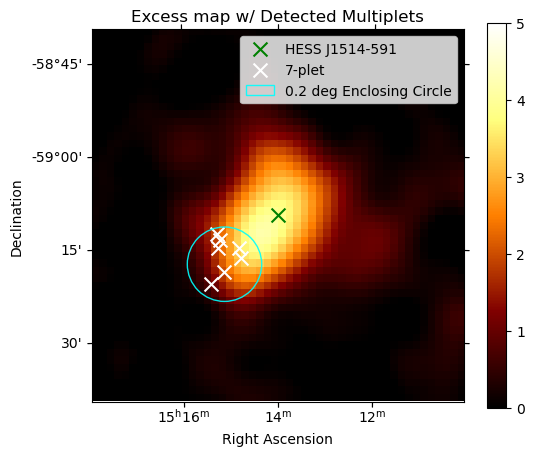

In [14]:
make_circle = smallest_enc_circ.make_circle
circ7_1 = make_circle(np.c_[sevenplets_40s[0]['RA'], sevenplets_40s[0]['DEC']])

wx = wy = 1 * u.deg
fig_ = plt.figure(figsize=(6, 5))
fig = stacked.excess.sum_over_axes().smooth(0.05 * u.deg).cutout(position=position_src, width=(wx, wy))
fig.plot(stretch = "linear", vmin=0, vmax=5,
                   add_cbar = True)


plt.gca().scatter(position_src.ra.deg, position_src.dec.deg, marker = 'x', color = 'green', transform=plt.gca().get_transform("icrs"), s=100, label = 'HESS J1514-591')

plt.gca().scatter(sevenplets_40s[0]['RA'], sevenplets_40s[0]['DEC'], marker = 'x', color = 'white', transform=plt.gca().get_transform("icrs"), s=100, label = '7-plet')


center_coord = SkyCoord(circ7_1[0], circ7_1[1], unit = 'deg', frame="icrs")
region = CircleSkyRegion(center_coord, radius=0.1*u.deg).to_pixel(fig.geom.wcs)
region.plot(ax = plt.gca(), edgecolor='cyan', alpha=0.9, lw=1, label = '0.2 deg Enclosing Circle')

plt.title("Excess map w/ Detected Multiplets")

plt.legend()
#plt.savefig("plots_paper/7plet_40s.pdf")